In [1]:
import chainer
from chainer import training, iterators, optimizers, serializers, Chain
import chainer.functions as F
import chainer.links as L
 
from chainer.training import extensions
from chainer.datasets import tuple_dataset
from chainer import optimizers, Chain, dataset, datasets, iterators
import numpy as np

In [2]:
def data_read( file_name, key_data, is_one_hot ):
    teachers = np.array([] )
    answers =  np.array([] )

    f = open( file_name, mode = "r" )

    f_string = f.readlines()

    day_data = np.array([] )
    tmp_data = np.array([] )
    for i in range( 0, len( f_string ) ):
        
        day_data = np.append( day_data, float(f_string[i].replace( "\n", "" )))
        
        # 一日のデータを格納する
        if( (i+1)%6 == 0 and i != 0 ):
            # 引数を軸にデータを教師データと正解ラベルに振り分ける
            if( (i+1)//6%key_data == 0):
                # 正解ラベルは終値
                teachers = np.append( teachers, tmp_data)
                # 正解ラベルをone hotで表現する場合
                if( is_one_hot ):
                    answers = np.append( answers, tmp_data[6 * (key_data - 1) - 3] > day_data[3])
                else:
                    answers = np.append( answers, day_data[3] )
                tmp_data = np.array([] )
            else:
                tmp_data = np.append( tmp_data, day_data)
                #teachers = np.append( teachers, day_data )
            day_data = np.array([] )
            
    f.close()

    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.float32 )

    #teachers = np.reshape( teachers, ( int( len( teachers ) / 6 ), 6 ) )
    #answers = np.reshape( answers, ( len( answers ) , 1 ) )

    return teachers, answers


In [3]:
def take_data(year, key_day, is_one_hot):
    file = open('nikkei.txt')
    stock_numbers = file.readlines()
    file.close()
    
    teachers = np.array([] )
    answers =  np.array([] )
    
    for number in stock_numbers:
        number = number.rstrip('\n')
        tmp_teacher, tmp_answer = data_read('./data/{}_{}.txt'.format(number, year), key_day, is_one_hot)
        teachers = np.append( teachers, tmp_teacher)
        answers = np.append( answers, tmp_answer)
        
    teachers = teachers.astype( np.float32 )
    answers = answers.astype( np.float32 )

    teachers = np.reshape( teachers, ( int( len( teachers ) / (6 * (key_day-1) ) ), 6 * (key_day-1) ) )
    answers = np.reshape( answers, ( len( answers ) , 1 ) )
    answers = answers.flat[:]

    return teachers, answers

In [4]:
#ニューラルネットワークの構築。
class MyChain(Chain):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(MyChain, self).__init__(
        l1=L.Linear(n_input, n_hidden[0]),
        l2=L.Linear(n_hidden[0], n_hidden[1]),
        #l3=L.Linear(n_hidden[1], n_output),
        l3=L.Linear(n_hidden[1], n_hidden[2]),
        l4=L.Linear(n_hidden[2], n_output),
        #l4=L.Linear(n_hidden[2], n_hidden[3]),
        #l5=L.Linear(n_hidden[3], n_hidden[4]),
        #l6=L.Linear(n_hidden[4], n_hidden[5]),
        #l7=L.Linear(n_hidden[5], n_hidden[5]),
        #l8=L.Linear(n_hidden[5], n_output),
    )
 
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        #o = self.l3(h2)
        h3 = F.relu(self.l3(h2))
        o = self.l4(h3)
        #o = F.relu(self.l4(h3))
        #h4 = F.relu(self.l4(h3))
        #h5 = F.relu(self.l5(h4))
        #h6 = F.relu(self.l6(h5))
        #h7 = F.relu(self.l7(h6))
        #o = self.l8(h7)
        return o

In [12]:
# 何日間のデータで学習させるか
key_data = 6

teachers, answers = take_data(2018, key_data, True)
teachers = teachers.astype(np.float32)
answers = answers.astype(np.int32)

#　教師データのtupleを作成する

data = datasets.TupleDataset(teachers, answers)

#総データの長さ
N = len(teachers)

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}

n_batchsize = 30
n_epoch = 100

#モデルを使う準備。オブジェクトを生成
n_input = (key_data-1)*6
n_hidden = [ (key_data-1)*6, (key_data-1)*3, key_data-1]
n_output = 2
model = L.Classifier(MyChain(n_input, n_hidden, n_output))
#model = MyChain(n_input, n_hidden, n_output)
optimizer = optimizers.Adam()
optimizer.setup(model)

#学習用データと検証用データに分ける
train, test = chainer.datasets.split_dataset_random(data, int(N * 0.8))
train_iter = chainer.iterators.SerialIterator(train, n_batchsize, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, n_batchsize, repeat=False, shuffle=False)
#print(test_iter.next()[0])
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (n_epoch, "epoch"), out="result")
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(10, "epoch"))) # 1エポックごとにログ出力
trainer.extend(extensions.PrintReport( ["epoch", "main/loss", "validation/main/loss", "main/accuracy", "validation/main/accuracy", "elapsed_time"])) # エポック、学習損失、テスト損失、学習正解率、テスト正解率、経過時間
#trainer.extend(extensions.ProgressBar()) # プログレスバー出力
#trainer.extend(extensions.dump_graph('main/accuracy'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
10          864.148     2.83365               0.522993       0.523714                  12.393        
20          0.814026    0.692213              0.524226       0.521667                  26.8327       
30          0.691751    0.692213              0.524264       0.521667                  42.6726       
40          0.691755    0.692213              0.524226       0.521667                  56.2663       
50          0.691753    0.692213              0.52424        0.521667                  70.0192       
60          0.691751    0.692213              0.524264       0.521667                  82.9858       
70          0.691755    0.692213              0.524226       0.521667                  96.0618       
80          0.691753    0.692213              0.52424        0.521667                  109.103       
90          0.691751    0.692213              0.524264       0.521667               

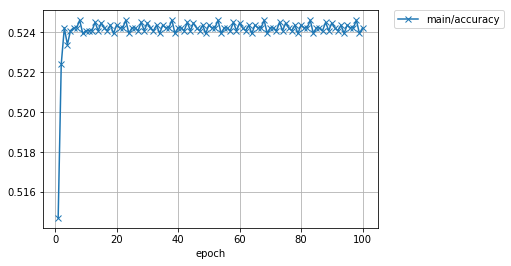

In [13]:
from IPython.display import Image, display_png
display_png(Image("./result/accuracy.png"))

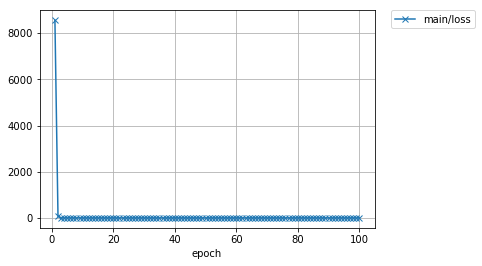

In [14]:
display_png(Image("./result/loss.png"))